In [241]:
# Import the neccesary python libraries for Bayesian analysis
# and data visualisation.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import stan as ps
import arviz as az
import statistics as Stats
import scipy.stats as stats
from patsy import dmatrix

# Universal variables
pp_samples = 100
# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply();

In [211]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Bayesian estimation of skew normal variable

The following notebook demonstrates a very useful but simple example of an application of Bayesian data analysis. That application being that if their is a parameterised probability distribution and you have enough data fitting a statistical model to that data based on that probability distribution in the form of a likelihood is feasible and therefore, so is statistical inference. Remember Bayesian data analysis is simply the application of Bayes rule, $P(\theta \mid y) = \large \frac{P(y \mid \theta) \, P(\theta)}{P(y)}$ to statistcal models Gelman et al. (2013).

For clarity, this may not be a surprise to any researchers who understand and apply maximum likelihood methods. However, that is a skillset not possessed and arguably not even within the purview of many psychological researchers who are taught statistical tests based or gaussian assumptions (Delacre, Lakens, & Leys, 2017, McElreath, 2020) and thus dominates their statistical practices. A primary advantage for researchers which this notebook hopes to show in a simple form is the use Bayesian data analysis to build better models that describe the data generating process for the phenomenon under study (Kruschke, 2015; McElreath, 2020).

Therefore, the example below demonstrates the fitting single group skew-normal model to some multiple observations of a single subjects reaction time data to a stroop task. In this example many researcher would apply a Null hypothesis significance test (NHST) likely in the form of one sample t-test or potentailly even non-parametric test when the data is skewed like the data here. A common resposne under the classical statistics NHST framework (Lachaud & Renaud, 2011). The exact issues with this are diverse and therefore not explained in any further detail here to focus on the task at hand.

# Steps of Bayesian data analysis

<font size = "3"> Kruschke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for the question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. If scientific research publication is the goal the priors must be accepted by a skeptical audience. Much of this can be achieved using prior predicitve checks to ascertain if the priors are reasonable.

4. Using Bayes' rule estimate the posterior for the parameters of the model using the likelihood and priors. Then interpret the posterior.

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

#  Step 1 - Identify the relevant data for  the question under investigation

The data that is analysed below actually comes from another Bayesian teaching resource https://vasishth.github.io/bayescogsci/book/ex-compbda.html. It is actually suggested as an end of chapter exercise. The author of this notebook openly admits they were struggling to find a nice example for a skew normal model to show a not so common application of Bayesian inference and thanks those authors for the inspiration. The authors of that textbook as far as the author of this notebook is aware advocate for open science/education and will not have an issues with the use of their data. Of course, if their are any issues please make the author of this notebook aware. Anyhow, the data is imported from the associated github page for online textbook linked above.

In [212]:
# Url variable for the raw data for the reaction times of the single participant.
url = 'https://raw.githubusercontent.com/bnicenboim/bcogsci/master/data-raw/datasets/button_press.csv'

In [213]:
# Generate pandas dataframe for the reaction time dataset
df = pd.read_csv(url)

In [214]:
# Output the headers of the dataset.
df.head(1)

,rt,trialn
0,141,1


## Exploratory data analysis

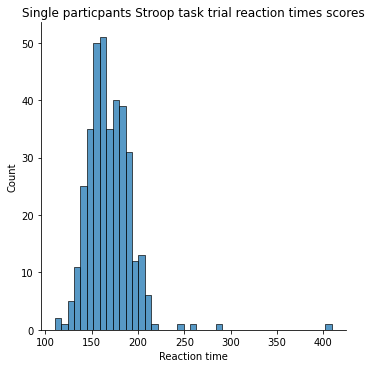

In [326]:
# Plot the reaction time data for the single participants repeated trial observations.
sns.displot(df['rt']);
plt.title('Single particpants Stroop task trial reaction times scores');
plt.xlabel('Reaction time');

# Step 2 - Define the descriptive statistical model \begin{align*}
y_{i} &\sim SkewNormal(\xi, \omega, \alpha)
\\ \xi &\sim Normal(\bar{y}, \sigma_y * 5)
\\ \omega &\sim Normal(0, \sigma_y * 10)
\\ \alpha &\sim Normal(0, 10)
\end{align*} 


### Step 3 - Specifying priors
The prior values here were selected to be broad and data informed in line with the suggestions of prior setting in Kruschke (2015). This is not such a problem here as there is large number of data points and the models are simple (low-dimensional).

## Stan model for skew-normal 

In [216]:
skew_normal = '''

// Functions defined here are simple but help dmeosntrate 
// and clean up the generated quantities block
// which is generaly appropriate with stan code. 

functions{
// Function to calculate the expected value of skew normal random variable. 
real skew_normal_mean(real xi, real omega, real alpha){
    real delta = alpha / sqrt(1 + pow(alpha, 2));
    real mean_sn = xi + omega * delta * sqrt(2/pi());
    return mean_sn;
    }
}

data{

int<lower = 1> N; // Set total observations
vector[N] y; // vector of dependent variable values

// Variable to specify if prior or posterior predictive checks are run.
int<lower = 0, upper = 1> onlyprior;

// Prior parameter values
real xi_mu;
real xi_sigma;
real omega_sigma;
real alpha_sigma;
}
parameters{

// Parameters for Stan parameterisation of skew normal distribution
real xi;
real<lower = 0> omega;
real alpha;

}

model{

// priors
xi ~ normal(xi_mu,xi_sigma);
omega ~ normal(0, omega_sigma);
// This prior represents that the skew could be in either left/right.
alpha ~ normal(0, alpha_sigma);

// Run likelihoood if onlyprior is set to 0
if(!onlyprior){
    y ~ skew_normal(xi, omega, alpha);
    }
}

generated quantities{
vector[N] yrep;
vector[N] log_lik;
real sn_mean;

sn_mean = skew_normal_mean(xi, omega, alpha);

// Need for loop as skew_normal_rng is not vectorisable. See Stan manual for updates
for(i in 1:N){
    yrep[i] = skew_normal_rng(xi, omega, alpha);
    }

// Only run log likelihood when posterior is estimated    
if(!onlyprior){
for (i in 1:N) {
    log_lik[i] = skew_normal_lpdf(y[i] | xi, omega, alpha);
      }
  }  
}
'''

In [217]:
# Generate python dictionary to be passed to stan during build of the model for later sampling.
data_sn = {'N': len(df),
        'y': df['rt'].values,
        #Set as 1 fro prior predictive checks
        'onlyprior': 0,
        'xi_mu': np.mean(df['rt']),
        'xi_sigma': np.std(df['rt']) * 5,
        'omega_sigma': np.std(df['rt']) * 10,
        'alpha_sigma': 10.,
           }

In [218]:
# Compile stan model tp C++ code
sm = ps.build(skew_normal, data = data_sn)

Building...



Building: found in cache, done.Messages from stanc:


In [219]:
# Sample from the Stan model.
fit = sm.sample(num_chains = 4);

Sampling:   0%
Sampling:   6% (500/8000)
Sampling:  31% (2500/8000)
Sampling:  56% (4500/8000)
Sampling:  81% (6500/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!


In [220]:
summ = az.summary(fit, var_names = ['xi', 'omega', 'alpha', 'sn_mean'])

In [221]:
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
xi,142.941,1.783,139.655,146.317,0.050,0.035,1295.0,1533.0,1.0
omega,35.955,1.849,32.436,39.410,0.048,0.034,1483.0,1350.0,1.0
alpha,2.616,0.374,1.893,3.289,0.010,0.007,1272.0,1646.0,1.0
sn_mean,169.662,1.255,167.199,171.920,0.018,0.013,4757.0,2995.0,1.0


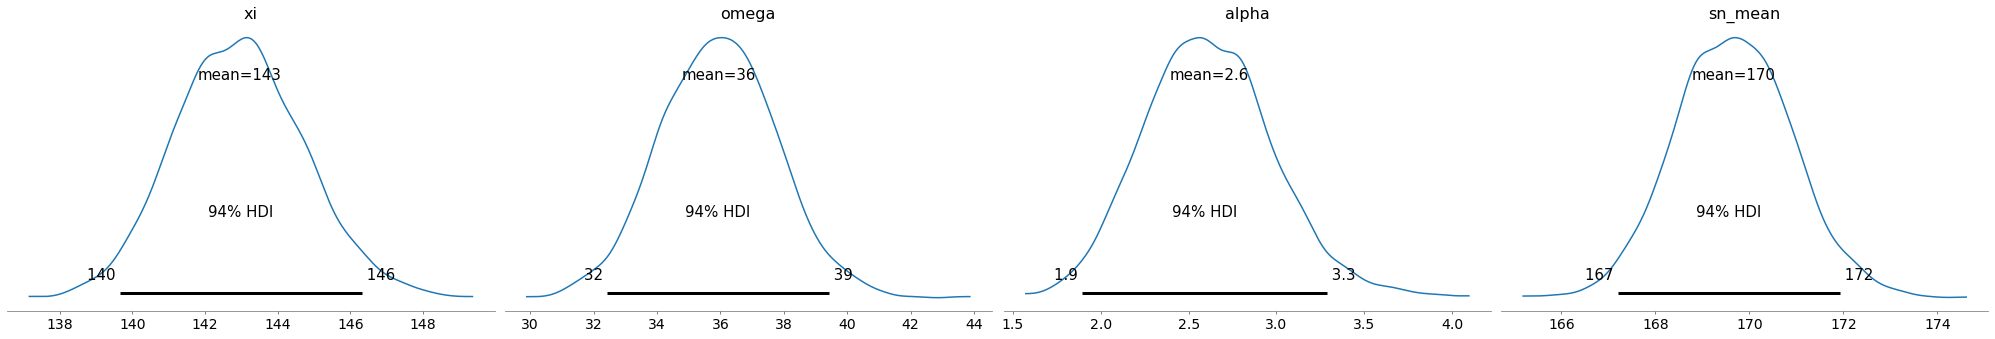

In [222]:
az.plot_posterior(fit, var_names = ['xi', 'omega', 'alpha', 'sn_mean']);

In [223]:
# Convert pystan fit object to IO for Arviz functions.
# Convert pystan fit object to IO for Arviz functions.
idata = az.from_pystan(posterior=fit, posterior_model=sm, log_likelihood = ['log_lik'], posterior_predictive=['yrep'],observed_data= 'y')

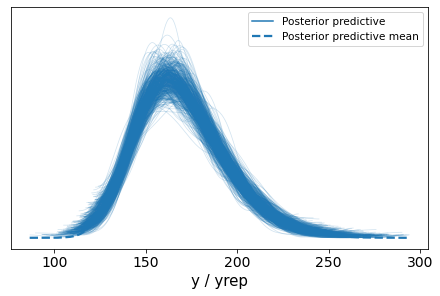

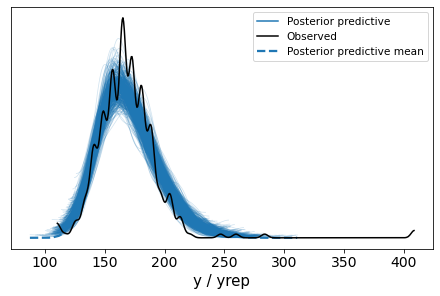

In [224]:
# Plot posterior simulated data sets for posterior predictive check
az.plot_ppc( idata, data_pairs= {"y" : "yrep"}, num_pp_samples= pp_samples, observed = False );
az.plot_ppc( idata, data_pairs= {"y" : "yrep"}, num_pp_samples= pp_samples, observed = True );

Posterior predcitive plots show that the skew normal model capture the participants reaction times fairly well. However, it fails to capture the outlier reaction. This is a result of the skew-normal unsurpsingly still have the skinny tail of the regular normal distribution.

# Can we do better?

## Lognormal model for reaction times


# Define the descriptive statistical model \begin{align*}
y_{i} &\sim LogNormal(\mu, \sigma)
\\ \mu &\sim Normal(6, 1.5)
\\ \sigma &\sim Normal(0, 1)
\end{align*} 

The prior values here were selected here as they are consistent to ones used in https://vasishth.github.io/bayescogsci/book/ex-compbda.html. The amount of data here again makes the priors less of a concern in this example.

### Stan model for lognormal

In [225]:
ln_model = '''
// Functions defined here are simple but help dmeosntrate 
// and clean up the generated quantities block
// which is generaly appropriate with stan code. 

functions{
real logn_median(real mu){
    return exp(mu);
}
real logn_mean(real mu , real sigma){
    return exp(mu + pow(sigma, 2) / 2);
    }
}

data{

int<lower = 1> N; // Set total observations
vector[N] y; // vector of dependent variable values

// Variable to specify if prior or posterior predictive checks are run.
int<lower = 0, upper = 1> onlyprior;

// Prior parameter values
real mu_mu;
real mu_sigma;
real sigma_sigma;
}
parameters{

// Parameters for Stan parameterisation of lognormal distribution
real mu;
real<lower = 0> sigma;

}

model{
// Priors
mu ~ normal(mu_mu, mu_sigma);
sigma ~ normal(0, sigma_sigma);

// Run likelihoood if onlyprior is set to 0
if(!onlyprior){
    y ~ lognormal(mu, sigma);
    }
}

generated quantities{
vector[N] yrep;
vector[N] log_lik;

// Calculate the posterior for the median value of a lognormal random variable.
real median_ln = logn_median(mu);

// Calculate the posterior for the mean value of a lognormal random variable.
real mean_ln = logn_mean(mu , sigma);

// Need for loop as skew_normal_rng is not vectorisable. see Stan manuals for updates
for(i in 1:N){
    yrep[i] = lognormal_rng(mu, sigma);
    }
    
// Only run log likelihood when posterior is estimated    
if(!onlyprior){
for (i in 1:N) {
    log_lik[i] = lognormal_lpdf(y[i] | mu, sigma);
      }
  }
}
'''

In [226]:
data_ln = {'N': len(df),
           'y': df['rt'].values,
           'onlyprior': 0,
           'mu_mu': 6.,
           'mu_sigma': 1.5,
           'sigma_sigma': 1.
          }

In [227]:
sm_ln = ps.build(ln_model, data = data_ln)

Building...



Building: found in cache, done.Messages from stanc:


In [228]:
fit_ln = sm_ln.sample(num_chains = 4)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/tmp/httpstan__jrd74ck/model_3swfvec4.stan', line 43, column 4 to column 29)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Except

  Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/tmp/httpstan__jrd74ck/model_3swfvec4.stan', line 43, column 4 to column 29)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in '/tmp/httpstan__jrd74ck/model_3swfvec4.stan', line 43, column 4 to column 29)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be

## Expected value of lognormal variable posteriors

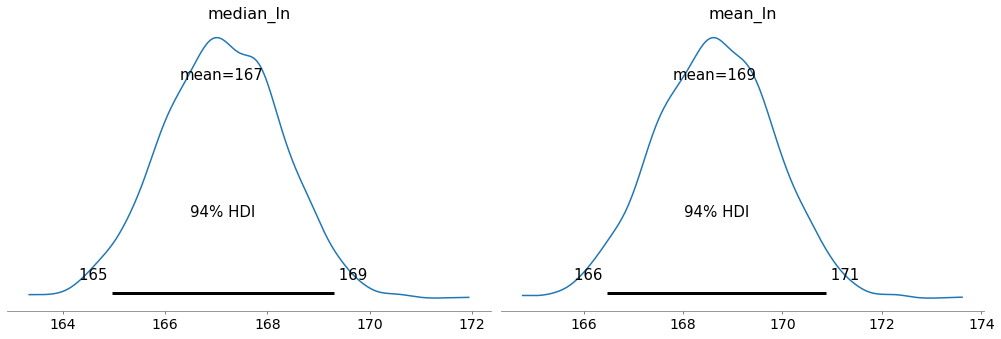

In [229]:
az.plot_posterior(fit_ln, var_names = ['median_ln', 'mean_ln']);

In [230]:
idata_ln = az.from_pystan(posterior = fit_ln, posterior_model = sm_ln, log_likelihood = ['log_lik'],
                          posterior_predictive=['yrep'],observed_data= 'y')

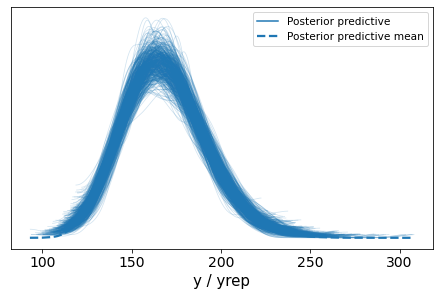

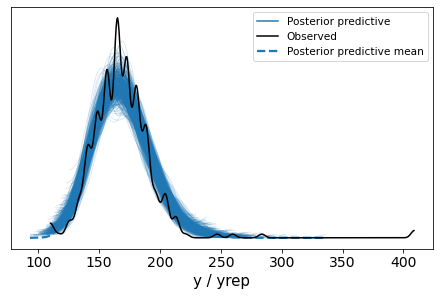

In [231]:
az.plot_ppc( idata_ln, data_pairs= {"y" : "yrep"}, num_pp_samples= pp_samples, observed = False );
az.plot_ppc( idata_ln, data_pairs= {"y" : "yrep"}, num_pp_samples= pp_samples, observed = True );

### How does a normal distribution model fair?

To coincide with what most psychological researchers are used to applying it is useful to see how a normal distributional model fairs when modelling this data set of reaction times.

## Define the descriptive statistical model \begin{align*}
y_{i} &\sim Normal(\mu, \sigma)
\\ \mu &\sim Normal(\bar{y}, \sigma_y * 5)
\\ \sigma &\sim Normal(0, \sigma_y * 10)
\end{align*} 

The prior values here were selected to coincide with the skew normal model as close as possible. Of course, the skewness parameter ($\alpha$) makes a large difference to the model skew-normal model

## Stan model for Normal

In [307]:
n_model = '''
data{

int<lower = 1> N; // Set total observations
vector[N] y; // vector of dependent variable values

// Variable to specify if prior or posterior predictive checks are run.
int<lower = 0, upper = 1> onlyprior;

// Prior parameter values
real mu_mu;
real mu_sigma;
real sigma_sigma;
}
parameters{

// Parameters for Stan parameterisation of lognormal distribution
real mu;
real<lower = 0> sigma;

}

model{
// Priors
mu ~ normal(mu_mu, mu_sigma);
sigma ~ normal(0, sigma_sigma);

// Run likelihoood if onlyprior is set to 0
if(!onlyprior){
    y ~ normal(mu, sigma);
    }
}

generated quantities{
vector[N] yrep;

vector[N] log_lik;
for (i in 1:N) {
    log_lik[i] = normal_lpdf(y[i] | mu, sigma);
      }

for(i in 1:N){
    yrep[i] = normal_rng(mu, sigma);
    }

}
'''

In [308]:
data_n = {'N': len(df),
           'y': df['rt'].values,
           'onlyprior': 0,
           'mu_mu': np.mean(df['rt']),
           'mu_sigma': np.std(df['rt']) * 5,
           'sigma_sigma': np.std(df['rt']) * 10,
          }

In [309]:
sm_n = ps.build(n_model, data = data_n)

Building...



Building: 41.1s, done.Messages from stanc:


In [310]:
fit_n = sm_n.sample(num_chains = 4)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!


In [311]:
summ_n = az.summary(fit_n, var_names = ['mu', 'sigma'])

In [312]:
summ_n

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,168.591,1.294,166.130,171.015,0.023,0.016,3284.0,2541.0,1.0
sigma,24.973,0.935,23.248,26.750,0.017,0.012,3158.0,2491.0,1.0


In [313]:
fit_n

<stan.Fit>
Parameters:
    mu: ()
    sigma: ()
    yrep: (361,)
    log_lik: (361,)
Draws: 4000

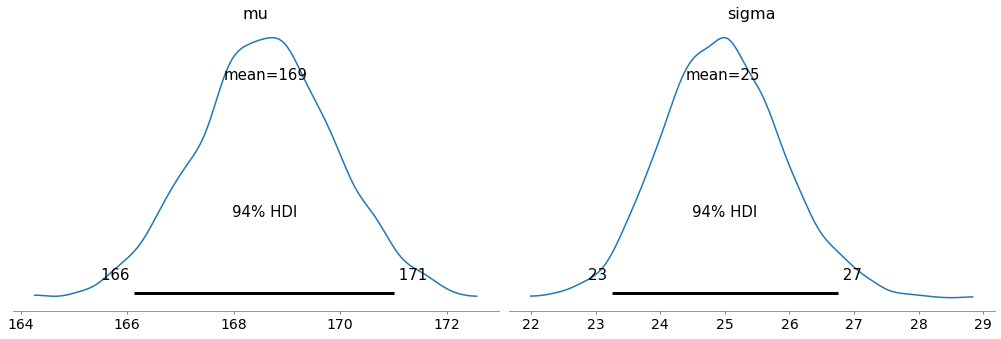

In [314]:
az.plot_posterior(fit_n, var_names = ['mu', 'sigma']);

In [315]:
# Convert pystan fit object to IO for Arviz functions.
# Convert pystan fit object to IO for Arviz functions.
idata_n = az.from_pystan(posterior=fit_n, posterior_model=sm, log_likelihood = ['log_lik'], 
                       posterior_predictive=['yrep'],observed_data= 'y')

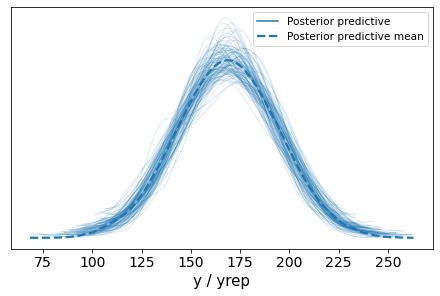

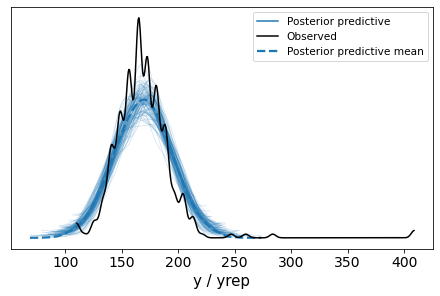

In [316]:
az.plot_ppc( idata_n, data_pairs= {"y" : "yrep"}, num_pp_samples= pp_samples, observed = False );
az.plot_ppc( idata_n, data_pairs= {"y" : "yrep"}, num_pp_samples= pp_samples, observed = True );

/home/users/bu807041/.local/lib/python3.7/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/users/bu807041/.local/lib/python3.7/site-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/users/bu807041/.local/lib/python3.7/site-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You shoul

          rank          loo      p_loo      d_loo        weight          se  \
Model_LN     0  3276.184615   4.714021   0.000000  1.000000e+00   56.749486   
Model_SN     1  3300.821120   9.660733  24.636505  0.000000e+00   68.289619   
Model_N      2  3361.676979  13.470008  85.492364  6.756817e-13  109.367495   

                dse  warning loo_scale  
Model_LN   0.000000    False  deviance  
Model_SN  14.316752     True  deviance  
Model_N   57.504433     True  deviance  


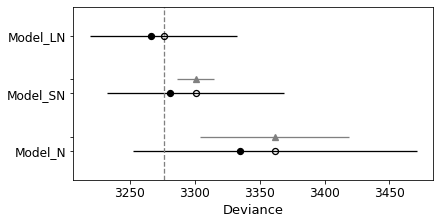

In [317]:
compare_dict = {"Model_SN": idata, "Model_LN": idata_ln, "Model_N": idata_n}
model_compare = az.compare(compare_dict, scale = 'deviance');
print(model_compare)
az.plot_compare(model_compare);

The model comparison results above show some interesting things. Firstly, he performance of the models in terms of out of sample prediction are not surprsing seeing as they are attempting to model reaction time data with the lognormal model performing the best. However, as the plot shows that this is only in terms of point estimation as their is a lot of overlap in terms of the error scores and that uncertainty increases as you go from LN-SN-N model. Another interesting outcome to look at with the model outcomes is that SN and N model both resulted in warnings for highly leveraging points where as LN did not. Which suggests that LN model was more robust and captured the outlier value.

Some final remarks. As this notebook has hopefully shown is that Bayesian data analysis offers robust and flexible modelling options. In addition, it should hopefully show that even in this simple situation more appropriate modelling options exist and that there are alternatives to the general dominance of gaussian assumptions within statisitcal tests. It has to be said though that application of these alternatives is often not as simple as gaussina tests. In that the gaussian distribution is nice, in that its easier to fit data with and requires less post work to understand. However, we can likely do better in situations that call for these alternatives, in additon to the reality that you would not have to commit to a single model and that studying multiple models might be frutiful in understanding psychological phenomena.

# References

Delacre, M., Lakens, D., & Leys, C. (2017). Why psychologists should by default use Welch’s t-test instead of Student’s t-test. International Review of Social Psychology, 30(1).

Kruschke, J. K., (2015). Doing bayesian data analysis: A tutorial with R, JAGS, and Stan. New york, NY: Academic Press.

Lachaud, C. M., & Renaud, O. (2011). A tutorial for analyzing human reaction times: How to filter data, manage missing values, and choose a statistical model. Applied Psycholinguistics, 32(2), 389-416.

McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan. Boca Raton: CRC Press.

## Exercises for the motivated readers

1. Change the prior parameter values and onlyprior variable (set to 1) in the python dictionaries for the models and see the effects on prior predictive distributions.

2. Fit a student-t distribution model and do model comparison to see the outcomes.

3. Use tighter priors on the models and observe the outcomes for posterior predictive checks and LOO estimates.